In [1]:
import topos
import topos.bp as bp
import fp

import torch
import matplotlib.pyplot as plt

plt.set_cmap('viridis')
#plt.style.use('dark_background')
imgdir = '/home/oli/math/maxEnt/Figures'

<Figure size 640x480 with 0 Axes>

# 2-loop Ising model

In [2]:
from bp_eight import Eight

N = Eight()
#--- underlying graph ---
G = N._classified


In [3]:
field = torch.linspace(-1, 1, 15)
beta  = torch.linspace(0, 2, 100)

H_0 = N.initial_conditions(field, beta)
print('H_O:', H_0.shape)

/home/oli/fp/fp/instances/tens.py:260: UserWarning: Sparse CSR tensor support is in beta state. If you miss a functionality in the sparse tensor support, please submit a feature request to https://github.com/pytorch/pytorch/issues. (Triggered internally at ../aten/src/ATen/SparseCsrTensorImpl.cpp:54.)
  data = torch.sparse.mm(f.data, g.data)


H_O: [15, 100, 34]


### Belief diffusion

In [4]:
GBP = bp.GBPDiffusion(N)
print(GBP)

def log_freeEnergy(H, n):
    print('yo', end='')
    
with GBP.write(D=N.freeDiff(1)) as W:
    H_1 = GBP.euler(.3, 100)(H_0)
    D = W['D']

diff_0 = N.freeDiff(1)(H_0).data.norm(-1).mean()
diff_1 = N.freeDiff(1)(H_1).data.norm(-1).mean()

print('H_1:', H_1.shape)
print('D(H_0):', float(diff_0), 'average norm')
print('D(H_1):', float(diff_1), 'average norm')


Diffusion N(G) : λ
H_1: [15, 100, 34]
D(H_0): 1.6116071037686197e-06 average norm
D(H_1): 0.0 average norm


### Free energy accross a singularity

torch.Size([5, 101, 101])


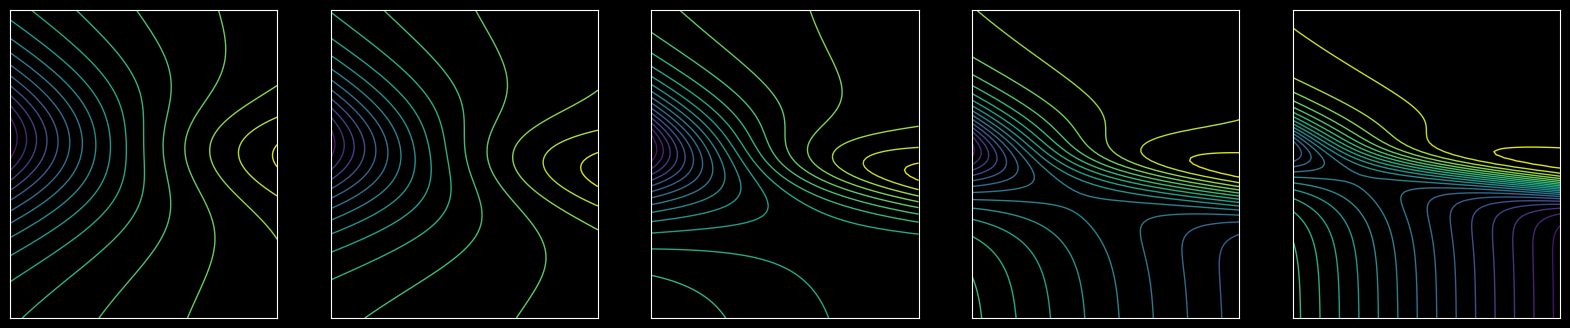

In [5]:
from topos.io import plot_contours

def radial_conservative(field=1, beta=None, gamma=None):
    """ Span of (U, V) with V = codiff(phi) """
    if beta is None:  beta  = torch.linspace(.4, 1.6, 101)
    if gamma is None: gamma = .5 * torch.linspace(-2, 1.3, 101)

    p_sg = N.singular_beliefs(field)
    U_sg = N._ln(p_sg)
    V_sg = N.zeta(N.codiff(N.eigen_flux(p_sg)))

    U = beta[:,None] * U_sg.data
    V = gamma[:,None] * V_sg.data
    return N[0].field(U + V[:,None,:])

field_UV = [.3, .6, 1, 1.3, 1.6]
UV = [radial_conservative(fi) for fi in field_UV]
UV = N.Field(0).batch(UV)

UV.shape
Fb = N.freeBethe(1.)(UV).data

Fb_med = Fb.max() - Fb.min()
fig = plot_contours(Fb, levels=20, lw=1.2)
fig.savefig(f'{imgdir}/singular_contours.svg')

Help on NoneType object:

class NoneType(object)
 |  Methods defined here:
 |  
 |  __bool__(self, /)
 |      True if self else False
 |  
 |  __repr__(self, /)
 |      Return repr(self).
 |  
 |  ----------------------------------------------------------------------
 |  Static methods defined here:
 |  
 |  __new__(*args, **kwargs) from builtins.type
 |      Create and return a new object.  See help(type) for accurate signature.



<Figure size 640x480 with 0 Axes>

torch.Size([24])


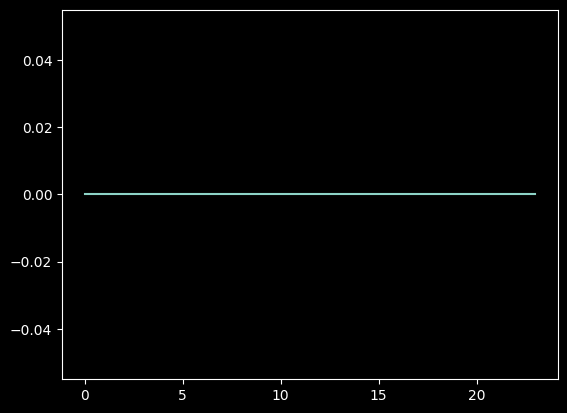

In [7]:
#p_sg = N.singular_beliefs(4)
p_sg = N.gibbs(0 * N.randn(0))
U_sg = N._ln(p_sg)
phi = N[1].field(torch.eye(N[1].size))
dU = N.zeta(N.codiff(phi))
U_0 = N[0].field(U_sg.data + .05 * dU.data)

V = GBP.euler(.3, 100)(U_0)
F = N.freeBethe(V)
plt.plot(F.data.sort(0).values)